## Trying to load in an image of run a bit of convolution on it

Step 1 - let's try and load an image into an RGB vector

In [103]:
## OK this one strip of code is going to hold everything



In [100]:
#import relevant modules
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt 

#NOW CREATE FUNCTIONS
#Function one - getting an image from a jpeg/png and turning it into an RGB vector
def turn_image_into_vector(file):
     
    image = Image.open(file) #use the Image.open() to open the file, but not do anything with it.

    rgb_array_of_image = np.array(image) #turn the image into a vector
    
    #print(f"What we have here is {rgb_array_of_image.shape[0]} x {rgb_array_of_image.shape[1]} image, with {rgb_array_of_image.shape[2]} colours in the palette"  ) #shows you what you have got getting rid of this for now
    return(rgb_array_of_image)

#function two - gets a vector and displays an image
def display_image(vector, title, size=(10,6)):
    fig = plt.figure(figsize=size)
    plt.imshow(vector)
    plt.title(title)
    plt.show()


#OK - NOW IT'S TIME TO CREATE THE CONVOLUTION MATRIX as a class

#define a class called convolution
class Blur_convolution():

#that class can have one of three names for now (e.g. blur, contract or edge detection) and a side length
    def __init__(self, length = 5, smooth = 'Gaussian', variance = 1):
            self.length = length
            self.smoother = smooth
            if smooth == 'Gaussian':
                self.variance = variance
                self.convol_array = self._create_gauss_matrix()
                
            else:
                #this is just a really simple flat matrix
                self.convol_array = np.zeros((length,length)) + 1/(length**2) 
    def _create_gauss_matrix(self):
            #Gaussian formula: (1/2.pi) * exp((-1/2)*(x-µ)T * (x-µ) ) 

                var = self.variance #this could change for future
                mean_x_y = (self.length-1)/2 #this is for later calc.

                matrix = np.zeros((self.length,self.length))


                #iterate over it enumeration-style
                for x, mat_row in enumerate(matrix):
                    for y, mat_col in enumerate(matrix[x,:]):
                        x_diff = x - mean_x_y #create the (x-µ) component
                        y_diff = y - mean_x_y
                        value_for_exp = -0.5*(x_diff**2 + y_diff**2)/(var) #this calculates the section of the mv gaussian after the exponent
                        pre_norm = np.exp(value_for_exp) #perfomr the exponent (RHS of equation)
                        post_norm = (1/(2*np.pi*np.sqrt(var*2)))*pre_norm #add back in the normalising constant
                        matrix[x][y] = post_norm #set the relevant cell in the matrix to that value

                #sadly, my normalising constant doesn't seem perfect, so doing a final normalisation at the end.
                matrix = matrix / np.sum(matrix)
                return matrix

            

#that convolution then has a method where it takes image(param1), and potentially something like ('padding=False') and returns outputted image 
    def transform_image(self, image, padding = False):
        #putting in some print_test_variables for later
        
        new_image = np.zeros_like(image)
        if padding == False:
            trim_len = int((self.length-1)/2)   #for repeated use later
            for palette in range(image.shape[2]): #so we're iterating overt the colour palettes, performing the same operation for each of them.
                for row_idx, row in enumerate(image[trim_len:image.shape[0]-trim_len,:,palette]):
                    for col_idx, column in enumerate(image[row_idx,trim_len:image.shape[1]-trim_len,palette]):
                            
                            #ok now we've got down to a specific point in the image we want to change
                            value_of_cell_to_be_calculated = 0  

                            #now let's get the rows and columns for which we need to iterate over when doing our calculation (takes the ones either side of that one)
                            list_of_rows_to_be_iterated_over = np.linspace(row_idx-trim_len,row_idx+trim_len,self.length) 
                            list_of_cols_to_be_iterated_over = np.linspace(col_idx-trim_len,col_idx+trim_len,self.length)

                           

                            #so we're going to iterate over that list, and also create an enumeration of it to be used for iterating over the convolution array and mult. together
                            for row_idx_for_convol_matrix, row_in_calc in enumerate(list_of_rows_to_be_iterated_over):                                
                                for col_idx_for_convol_matrix, col_in_calc in enumerate(list_of_cols_to_be_iterated_over):
                                    value_of_cell_to_be_calculated += image[int(row_in_calc),int(col_in_calc),palette] * self.convol_array[row_idx_for_convol_matrix,col_idx_for_convol_matrix]
                                    
                            #Then, set that cell of the new_image to that value.
                            new_image[row_idx,col_idx,palette] = value_of_cell_to_be_calculated
                           
            return new_image[:-(self.length-1),:-(self.length-1),:] #cuts off the now black cells round the edge

#OK, now what's the order of running things:
def end_to_end_image_blur_function(file, length = 'auto', image_name = 'Original', smoothing = 'Gaussian', variance = 1,  padding = False):
    
    #first thing is turn image into vector
    vector_of_image = turn_image_into_vector(file)

    #next thing is create a length for the convoluter if length is 'auto'
    if length == 'auto':
        #we want to make length odd. and it should be roughly between a third root and second root the length of the image
        length = round(vector_of_image.shape[0] **0.33) * 2 + 1 #timesing by 2 on the end there makes it even then + 1 makes it odd
        print(f"we automatically chose for you a {length} by {length} matrix")

    #then we need to initialise a Blur_convolution object
    blurrer = Blur_convolution(length = length, smooth = smoothing, variance = variance)

    #then we need to run the transform_image function of blurrer which returns a new vector
    blurred_vector = blurrer.transform_image(vector_of_image,padding = padding) 

    print(f"This was your image:\n")
    display_image(vector_of_image,image_name)
    
    print(f"\nThis is what it looks like now!\n")
    display_image(blurred_vector,'After convolution')
    

This was your image:



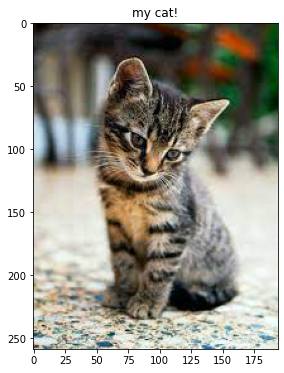


This is what it looks like now!



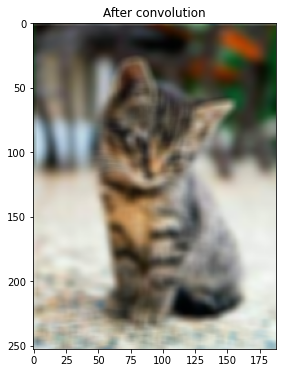

In [102]:
file = 'Cat_image.jpeg' #load image destination into file variable

end_to_end_image_blur_function(file, smoothing = 'flat',length = 7, image_name = "my cat!")

# ignore code below here - old.

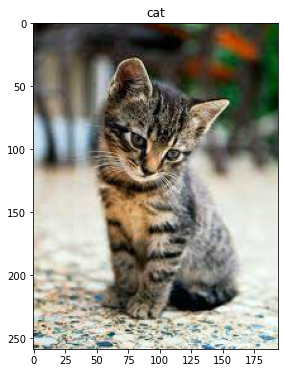

What we have here is 259 x 194 image, with 3 colours in the palette


In [89]:


import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt 

#defintion one - getting an image from a jpeg/png and turning it into an RGB vector
def turn_image_into_vector(file):
     
    image = Image.open(file) #use the Image.open() to open the file, but not do anything with it.

    rgb_array_of_image = np.array(image) #turn the image into a vector
    
    print(f"What we have here is {rgb_array_of_image.shape[0]} x {rgb_array_of_image.shape[1]} image, with {rgb_array_of_image.shape[2]} colours in the palette"  ) #shows you what you have got
    return(rgb_array_of_image)

#function two - gets a vector and displays an image
def display_image(vector, title, size=(10,6)):
    fig = plt.figure(figsize=size)
    plt.imshow(vector)
    plt.title(title)
    plt.show()

display_image(cat_image_array,'cat')

file = 'Cat_image.jpeg' #load image destination into file variable
cat_image_array = turn_image_into_vector(file)

the array looks like this 
[[0.00670968 0.01106239 0.01493267 0.01650315 0.01493267 0.01106239
  0.00670968]
 [0.01106239 0.0182388  0.02461981 0.0272091  0.02461981 0.0182388
  0.01106239]
 [0.01493267 0.02461981 0.03323327 0.03672844 0.03323327 0.02461981
  0.01493267]
 [0.01650315 0.0272091  0.03672844 0.04059121 0.03672844 0.0272091
  0.01650315]
 [0.01493267 0.02461981 0.03323327 0.03672844 0.03323327 0.02461981
  0.01493267]
 [0.01106239 0.0182388  0.02461981 0.0272091  0.02461981 0.0182388
  0.01106239]
 [0.00670968 0.01106239 0.01493267 0.01650315 0.01493267 0.01106239
  0.00670968]]
the original image was 259 by 194 pixels


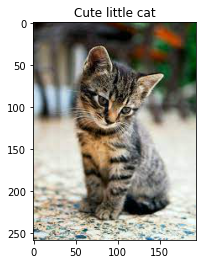

/nthe new image is 253 by 188 pixels


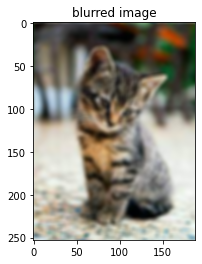

In [83]:
test = Blur_convolution(length = 7, variance =5)


converted_image = test.transform_image(cat_image_array,padding = False)

print(f"the original image was {cat_image_array.shape[0]} by {cat_image_array.shape[1]} pixels")

plt.imshow(cat_image_array)
plt.title('Cute little cat')
plt.show()

print(f"/nthe new image is {converted_image.shape[0]} by {converted_image.shape[1]} pixels")

plt.imshow(converted_image)
plt.title("blurred image")
plt.show()

print(f"\n\nYour convolution array looks like this \n{test.convol_array}")

In [80]:
#Gaussian formula: (1/2.pi) * exp((-1/2)*(x-µ)T * (x-µ) ) 

#first take in the inputs, length of the matrix, and the variance
length_of_mat = 5
var = 5 #this could change for future
mean_x_y = (length_of_mat-1)/2 #this is for later calc.

matrix = np.zeros((length_of_mat,length_of_mat))


#iterate over it enumeration-style
for x, mat_row in enumerate(matrix):
    for y, mat_col in enumerate(matrix[x,:]):
        x_diff = x - mean_x_y #create the (x-µ) component
        y_diff = y - mean_x_y
        value_for_exp = -0.5*(x_diff**2 + y_diff**2)/(var) #this calculates the section of the mv gaussian after the exponent
        pre_norm = np.exp(value_for_exp) #perfomr the exponent (RHS of equation)
        post_norm = (1/(2*np.pi*np.sqrt(var*2)))*pre_norm #add back in the normalising constant
        matrix[x][y] = post_norm #set the relevant cell in the matrix to that value

#sadly, my normalising constant doesn't seem perfect, so doing a final normalisation at the end.
matrix = matrix / np.sum(matrix)